In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from nilearn import image
import os
from batchgenerators.dataloading.data_loader import DataLoaderBase


/home/marci/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
class DataLoader(DataLoaderBase):
    INPUT_SHAPE = (320, 320, 80)
    LAST_CHANNEL_NO = INPUT_SHAPE[2]

    def __init__(self, data, BATCH_SIZE=2, num_batches=None, seed=False):
        super(DataLoader, self).__init__(data, BATCH_SIZE, num_batches, seed) 
        
        self.batch_size = BATCH_SIZE
        self.classes = 2

    def generate_train_batch(self):
        # usually you would now select random instances of your data. We only have one therefore we skip this
        ind = np.random.choice(self._data, self.batch_size)
        imgs, labels = self._load_batch(ind)
        imgs = np.rollaxis(imgs, 3, 1)  
        labels = np.rollaxis(labels, 3, 1)
        print(imgs.shape)
        print(labels.shape)


        
        # now construct the dictionary and return it. np.float32 cast because most networks take float
        return {'data':imgs, "seg" : labels}
    
    def load_image(self, data):
        img = image.smooth_img("imagesTr/la_004.nii.gz", None).get_data()[:,:,:80]
        return img
    
    def _load_batch(self, ind):
        imgs = []
        labels = []
        for i in ind:
            s = i.split("/")
            img = image.smooth_img(i, None).get_data()[:, :, :self.LAST_CHANNEL_NO]
            imgs.append(img)

            label_path_name = f'labelsTr/{s[1]}'
            label = image.smooth_img(label_path_name, None).get_data()[:, :, :self.LAST_CHANNEL_NO]
            labels.append(label)
        return np.array(imgs), np.array(labels)



In [3]:
    INPUT_SHAPE = (320, 320, 80)
    LAST_CHANNEL_NO = INPUT_SHAPE[2]

    IMG_PATH = "imagesTr/"
    LABEL_PATH = "labelsTr/"

    def _create_path_list( path):
        return_list = []
        for i in os.listdir(path):
            temp_path = os.path.join(path, i)
            return_list.append(temp_path)
        return return_list


In [4]:
image_paths = _create_path_list(IMG_PATH)
label_paths = _create_path_list(LABEL_PATH)

In [5]:
batchgen = DataLoader(image_paths, 1)

def plot_batch(batch):
    batch_size = batch['data'].shape[0]
    plt.figure(figsize=(16, 10))
    for i in range(batch_size):
        plt.figure()
        plt.imshow(batch['data'][i,50,:,:]) 
        plt.imshow(batch['seg'][i,50,:,:], alpha=0.3)
    plt.show()


/home/marci/.local/lib/python3.6/site-packages/batchgenerators/dataloading/data_loader.py:53: DeprecationWarning: This DataLoader will soon be removed. Migrate everything to SlimDataLoaderBase now!
  warn("This DataLoader will soon be removed. Migrate everything to SlimDataLoaderBase now!", DeprecationWarning)


(1, 80, 320, 320)
(1, 80, 320, 320)


<Figure size 1152x720 with 0 Axes>

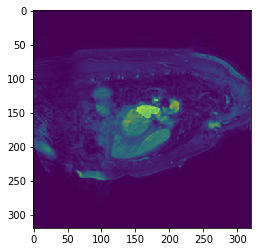

In [6]:
batch = next(batchgen)


plot_batch(batch)


In [7]:
batch["seg"].shape

(1, 80, 320, 320)

In [8]:
from batchgenerators.transforms.color_transforms import ContrastAugmentationTransform
from batchgenerators.transforms.spatial_transforms import MirrorTransform
from batchgenerators.transforms.abstract_transforms import Compose
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter
from batchgenerators.transforms.spatial_transforms import SpatialTransform_2

In [9]:
patch_size = (1, 80, 320, 320)

In [10]:
my_transforms = []

my_transforms.append(
        SpatialTransform_2(
            patch_size, [i // 2 for i in patch_size],
            do_elastic_deform=True, deformation_scale=(0, 0.25),
            do_rotation=True,
            angle_x=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi),
            angle_y=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi),
            angle_z=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi),
            do_scale=True, scale=(0.75, 1.25),
            border_mode_data='constant', border_cval_data=0,
            border_mode_seg='constant', border_cval_seg=0,
            order_seg=1, order_data=3,
            random_crop=True,
            p_el_per_sample=0.1, p_rot_per_sample=0.1, p_scale_per_sample=0.1
        )
    )


#mirror_transform = MirrorTransform(axes=(0,1,2))
#my_transforms.append(mirror_transform)



all_transforms = Compose(my_transforms)
multithreaded_generator = MultiThreadedAugmenter(batchgen, all_transforms, 4, 2, seeds=None)


In [11]:
test = multithreaded_generator.next()

(1, 80, 320, 320)
(1, 80, 320, 320)
(1, 80, 320, 320)
(1, 80, 320, 320)
(1, 80, 320, 320)
(1, 80, 320, 320)
(1, 80, 320, 320)
(1, 80, 320, 320)
Exception in worker 0


Traceback (most recent call last):


Exception in worker 1


  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/dataloading/multi_threaded_augmenter.py", line 50, in producer
    item = transform(**item)
Traceback (most recent call last):
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/transforms/abstract_transforms.py", line 88, in __call__
    data_dict = t(**data_dict)
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/transforms/spatial_transforms.py", line 459, in __call__
    p_rot_per_sample=self.p_rot_per_sample)
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/dataloading/multi_threaded_augmenter.py", line 50, in producer
    item = transform(**item)
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/augmentations/spatial_transformations.py", line 424, in augment_spatial_2
    d, s = random_crop_aug(data[sample_id:sample_id + 1], s, patch_size, margin)
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/augmentatio

Exception in worker 3


Traceback (most recent call last):
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/dataloading/multi_threaded_augmenter.py", line 50, in producer
    item = transform(**item)
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/transforms/abstract_transforms.py", line 88, in __call__
    data_dict = t(**data_dict)
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/transforms/spatial_transforms.py", line 459, in __call__
    p_rot_per_sample=self.p_rot_per_sample)
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/augmentations/spatial_transformations.py", line 424, in augment_spatial_2
    d, s = random_crop_aug(data[sample_id:sample_id + 1], s, patch_size, margin)
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/augmentations/crop_and_pad_augmentations.py", line 145, in random_crop
    return crop(data, seg, crop_size, margins, 'random')
  File "/home/marci/.local/lib/python3.6/site-

Exception in worker 2


Traceback (most recent call last):
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/dataloading/multi_threaded_augmenter.py", line 50, in producer
    item = transform(**item)
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/transforms/abstract_transforms.py", line 88, in __call__
    data_dict = t(**data_dict)
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/transforms/spatial_transforms.py", line 459, in __call__
    p_rot_per_sample=self.p_rot_per_sample)
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/augmentations/spatial_transformations.py", line 424, in augment_spatial_2
    d, s = random_crop_aug(data[sample_id:sample_id + 1], s, patch_size, margin)
  File "/home/marci/.local/lib/python3.6/site-packages/batchgenerators/augmentations/crop_and_pad_augmentations.py", line 145, in random_crop
    return crop(data, seg, crop_size, margins, 'random')
  File "/home/marci/.local/lib/python3.6/site-

RuntimeError: MultiThreadedAugmenter.abort_event was set, something went wrong. Maybe one of your workers crashed

In [ ]:
plot_batch(test)